# Orbital Mechanics Notebook
Michael Remley

In [ ]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math as math

First we need to define units:

In [15]:
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
AU = UNITS.astronomical_unit
s = UNITS.second
year = UNITS.years;

Then we define some initial values:

In [27]:
r_0 = (1 * AU).to_base_units()/m
v_0 = 0 * m / s
init = State(x=r_0,
             y=0,
             vx=0,
             vy=-30.33e3)


,values
x,149597870691.0 dimensionless
y,0
vx,0
vy,-30330


In [17]:
r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=((1.06*UNITS.year).to(UNITS.second)))

,values
init,x 149597870691.0 dimensionless y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,33450341.533182003 second


This function calculates force between our two masses using a state and system.

In [31]:
def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x,y,vx,vy = state
    unpack(system)
    
    r = sqrt(x**2 + y**2)
    force = G * m1 * m2 / r**2
    direction = math.atan2(y,x) + pi 
    force = Vector(force * math.cos(direction), force*math.sin(direction) )
    return force/m

In [32]:
universal_gravitation(init, system)

<Quantity([-3.54233769e+22  4.33811252e+06], 'meter * newton')>

Here's a slope function for the ode solver. It keeps track of position and velocity vectors.

In [20]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x,y,vx,vy = state
    unpack(system)    

    force = universal_gravitation(state, system)
    dxdt = Vector(vx,vy)
    dvdt = force / m2
    
    return dxdt, dvdt

In [33]:
slope_func(init, 0, system)

(<Quantity([     0. -30330.], 'dimensionless')>,
 <Quantity([-5.93157685e-03  7.26408660e-19], 'meter * newton / kilogram')>)

The event function returns the difference between r and its final value, stopping the solver when the masses collide.

In [34]:
def event_func(state, t, system):
    x,y,vx,vy = state
    r = sqrt(x**2 + y**2) * m
    return r - system.r_final

In [35]:
event_func(init, 0, system)

<Quantity(148895991691.0, 'meter')>

Here we run the simulation with the RK23 method, then change our units to millions of kilometers.

In [24]:
ts = linspace(t_0, system.t_end, 500)*s
results, details = run_ode_solver(system, slope_func,vectorized=True, events=event_func, t_eval=ts,method="RK23")
results.index /= 60 * 60 * 25
results.x /= 1e9
results.y /= 1e9
details

,values
sol,None
t_events,[[]]
nfev,137
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


This is the first way of representing the data, but it doesn't tell us much about the orbit.

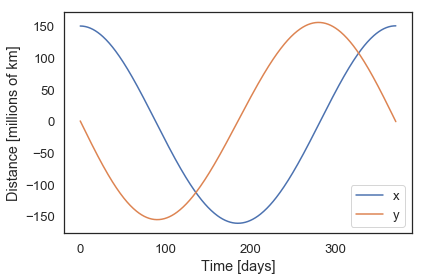

In [25]:
results.x.plot()
results.y.plot()
decorate(ylabel='Distance [millions of km]',
        xlabel='Time [days]')

Plotting y vs x, we can see the obvious shape of the orbit and confirm that it returns to where it started.

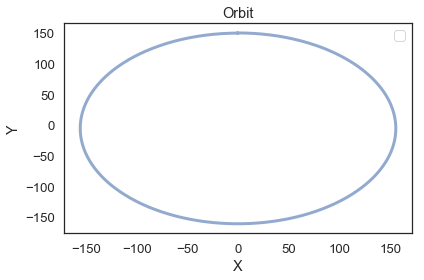

In [26]:
plot(results.y,results.x)
decorate(xlabel='X',
        ylabel='Y',
        title='Orbit')

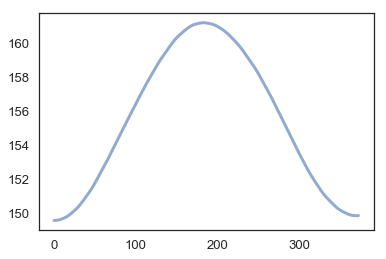

In [36]:
radius = (results.x**2 + results.y**2)**0.5
plot(radius)